In [ ]:
#!pip install fhirclient

In [22]:
# Import modules and classes for working with FHIR resources
from fhirclient import client
from fhirclient.models.patient import Patient
from fhirclient.models.condition import Condition
from fhirclient.models.observation import Observation
from fhirclient.models.medicationadministration import MedicationAdministration
from fhirclient.models.medicationrequest import MedicationRequest

from datetime import datetime
from dateutil.relativedelta import relativedelta
now = datetime.now()

In [2]:
settings = {
    'app_id': 'my_web_app',
    'api_base': 'http://api-v5-stu3.hspconsortium.org/MigrainApp/open'
}
smart = client.FHIRClient(settings=settings)


In [5]:
#Patient Demographics
patient = Patient.read('cf-1519578984350', smart.server)
DOB =datetime.strptime(patient.birthDate.isostring, '%Y-%m-%d')
print ('Patient Name:',patient.name[0].given[0], patient.name[0].given[1],patient.name[0].family)
print ('Patient DOB:', DOB.date())

Patient Name: Julie Margaret Doe
Patient DOB: 2005-05-04


In [6]:
# How is a single patient represented?
patient.as_json()

{'address': [{'city': 'Salt Lake City',
   'line': ['123 Some Place'],
   'postalCode': '84103',
   'state': 'UT'}],
 'birthDate': '2005-05-04',
 'gender': 'female',
 'id': 'cf-1519578984350',
 'identifier': [{'value': 'Pat-1'}],
 'meta': {'lastUpdated': '2018-02-26T20:53:56.000+00:00', 'versionId': '1'},
 'name': [{'family': 'Doe', 'given': ['Julie', 'Margaret']}],
 'resourceType': 'Patient',
 'telecom': [{'system': 'phone', 'use': 'home', 'value': '801-123-4567'}],
 'text': {'div': '<div xmlns="http://www.w3.org/1999/xhtml"><a name="mm"></a></div>',
  'status': 'generated'}}

In [8]:
# Let's look at a single condition instance
cond = Condition.read("cf-1519595561149", smart.server)


In [9]:
cond.as_json()

{'asserter': {'reference': 'Patient/cf-1519578984350'},
 'clinicalStatus': 'active',
 'code': {'coding': [{'code': '25064002',
    'display': 'Headache',
    'system': 'http://snomed.info/sct'}]},
 'id': 'cf-1519595561149',
 'identifier': [{'value': 'Head-4'}],
 'meta': {'lastUpdated': '2018-02-26T20:53:56.000+00:00', 'versionId': '1'},
 'onsetDateTime': '2018-01-02T16:00:00.000Z',
 'resourceType': 'Condition',
 'subject': {'reference': 'Patient/cf-1519578984350'},
 'text': {'div': '<div xmlns="http://www.w3.org/1999/xhtml"><a name="mm"></a></div>',
  'status': 'generated'},
 'verificationStatus': 'confirmed'}

In [49]:
# Let's now try searching for all conditions 
# that have Julie as a patient
# TODO: see how we're linking Julie's headaches to her care partner
# TODO: Why is this 10?
search = Condition.where({"patient": 'Patient/cf-1519578984350'})
conds = search.perform_resources(smart.server)
print(len(conds))

10


In [50]:
def display_condition(cond):
    """
    A helper function that will print out a
    fhirclient.models.condition.Condition
    in a more human-readable format
    """
    print("Resource ID: {}".format(cond.id))
    print("Resource Display: {}".format(cond.code.coding[0].display))
    print("Asserter Reference: {}".format(cond.asserter.reference))
    print("Subject reference: {}".format(cond.subject.reference))
    print("Datetime: {}".format(cond.onsetDateTime.isostring))
    
    
    print()
    #print(cond.as_json())
    
    
display_condition(conds[0])

Resource ID: cf-1519595561149
Resource Display: Headache
Asserter Reference: Patient/cf-1519578984350
Subject reference: Patient/cf-1519578984350
Datetime: 2018-01-02T16:00:00Z



In [13]:
# Let's look at the conditions created by Julie's mother
search = Condition.where({"asserter": 'RelatedPerson/cf-1519579101695'})
conds = search.perform_resources(smart.server)
print(len(conds))

5


### Let's walk through a couple of use cases

## Use Case 1: Pull headache pain severities from server, sort them and graph them

Headaches are modeled as `Conditions`, while the pain values are modeled as `Observations`. I'm not sure if they're linked right now, so for now I'm just going to work with the `Observations` (pain levels)

In [17]:
# A simple data dictionary
data_dict = {
    'patient_ref': 'Patient/cf-1519578984350',
    'headache_code': '25064002',
    'pain_sev_code': 'LA25253-8'
}

In [18]:
search = Observation.where({'subject': data_dict['patient_ref'],
                               'code': data_dict['pain_sev_code']})
observations = search.perform_resources(smart.server)


In [19]:
obs = observations[0]
obs.effectiveDateTime.date

datetime.datetime(2018, 1, 4, 18, 0, tzinfo=<isodate.tzinfo.Utc object at 0x111e2f860>)

In [20]:
# Now let's sort these by date
observations.sort(key=lambda x:x.effectiveDateTime.date)

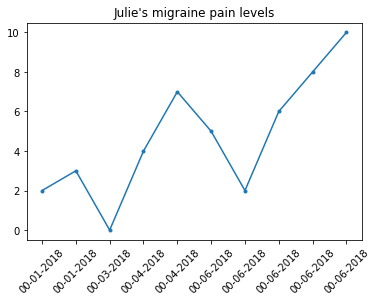

In [52]:
# Now let's plot it
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(observations))
x_labels = [obs.effectiveDateTime.date.strftime("%M-%d-%Y") for obs in observations]
x_labels

y = [o.valueQuantity.value for o in observations]


plt.plot(x, y, marker='.')
plt.title("Julie's migraine pain levels")

_ = plt.xticks(x, x_labels, rotation=45)


## Use Case 2: Get the list of the patient's active medications.

In [23]:
search = MedicationRequest.where({'subject': data_dict['patient_ref'],
                                   'status': 'active'})
med_requests = search.perform_resources(smart.server)
print(len(med_requests))

7


In [24]:
for med in med_requests:
    name = med.medicationCodeableConcept.coding[0].display
    instructions = med.dosageInstruction[0].text
    print('{} -- {}\n'.format(name, instructions))
    

Riboflavin -- 200mg PO DAILY

Ubidecarenone -- 200 mg PO THREE TIMES PER WEEK

Divalproex sodium 250mg tablet delayed release -- 1 TAB PO TWICE DAILY

Ibuprofen 200 mg oral tablet -- 1 TAB PO THREE TIMES PER WEEK

Amitriptyline hydrochloride 50 mg oral tablet -- 1 TAB PO DAILY

Metoclopramide hydrochloride 10 mg oral tablet -- 1 TAB PO BID

Sumatriptan 50 mg oral tablet -- 1 TAB PO THREE TIMES PER WEEK



## Use Case 3: Take an observation and condition and convert it into an `Entry`-like object that looks like what the front end produces/accepts

In [25]:
# Query using the subject and code
# Headaches are modeled as "Conditions
search = Condition.where({'subject': data_dict['patient_ref'], 
                            'code': data_dict['headache_code']})
headaches = search.perform_resources(smart.server)
print(len(headaches))

10


In [26]:
# We're going to naively just connect two that have the same date
headache = headaches[1]
headache.as_json()

for pain_level in observations:
    if pain_level.effectiveDateTime.date == headache.onsetDateTime.date:
        break
print(headache.onsetDateTime.date)
print(pain_level.effectiveDateTime.date)
    

2018-01-06 16:00:00+00:00
2018-01-06 16:00:00+00:00


The front-end new entry form as currently designed produces a json object similar to the one found at entry.json:

In [27]:
import json
with open('entry.json') as f:
    example = json.load(f)
example

{'author': "Mrs. Julia's Mom",
 'date': '2018-02-8',
 'entries': {'comments': 'Julie was in a lot of pain today.',
  'headache': {'date': '2018-08-07', 'severity': '6', 'time': '22:06'},
  'medications': [{'date': '2018-02-6',
    'idx': '0',
    'name': 'Ibuprofen 200mg',
    'time': '10:06'}],
  'triggers': [{'date': '2018-02-8',
    'idx': '0',
    'name': 'Lack of Sleep',
    'time': '10:06'},
   {'date': '2018-02-06', 'idx': '1', 'name': 'Light', 'time': '10:07'}]},
 'id': 'Entry-1',
 'time': '10:06'}

We're going to create something similar using some of the resources that we've pulled. All that we have right now are headachesand their respective pain levels, so we'll leave the other entries blank (along with some new free text comments).

In [28]:
# Start with an entry with empty fields
entry = { 'id': 'Entry-1',
         'date': now.strftime('%Y-%m-%d'),
         'time': now.strftime('%H:%m'),
        'author': '',
        'entries': {
            'headache': {},
            'medications': [],
            'triggers': [],
        }}
entry

{'author': '',
 'date': '2018-03-14',
 'entries': {'headache': {}, 'medications': [], 'triggers': []},
 'id': 'Entry-1',
 'time': '19:03'}

In [29]:
# Set the author attribute. 
# We'd eventually want to map clinfhir id's to usernames
# We'll do something similar but simple now
ref_to_user = {'Patient/cf-1519578984350': 'Julie Margaret Doe'}
entry['author'] = ref_to_user[headache.asserter.reference]
entry

{'author': 'Julie Margaret Doe',
 'date': '2018-03-14',
 'entries': {'headache': {}, 'medications': [], 'triggers': []},
 'id': 'Entry-1',
 'time': '19:03'}

In [30]:
# Let's create some free text
entry['entries']['comments'] = "I was in a lot of pain today. I'm not sure what caused it."

In [31]:
# Now let's format our headache
headache_entry = {}
headache_entry['severity'] = str(pain_level.valueQuantity.value)
headache_entry['date'] = datetime.strftime(headache.onsetDateTime.date, '%Y-%m-%d')
headache_entry['time'] = datetime.strftime(headache.onsetDateTime.date, '%H:%M')
headache_entry

{'date': '2018-01-06', 'severity': '2', 'time': '16:00'}

In [32]:
entry['entries']['headache'] = headache_entry
entry

{'author': 'Julie Margaret Doe',
 'date': '2018-03-14',
 'entries': {'comments': "I was in a lot of pain today. I'm not sure what caused it.",
  'headache': {'date': '2018-01-06', 'severity': '2', 'time': '16:00'},
  'medications': [],
  'triggers': []},
 'id': 'Entry-1',
 'time': '19:03'}

This now looks pretty similar to what our front end generates. We could hypothetically pass this to our front end through an HTTP POST, but for now we'll just save it to a new file to prove that this works.

In [33]:
with open('python_entry.json', 'w') as f:
    json.dump(entry, f)

## Use Case 4: Let's do the reverse: we'll take a json object that was created by the front end and create a fhir resource out of it. Then, can we push it to the server?

This will eventually be passed through HTTP, but for now we'll just load it from a file.

For simplicity, we'll use the very minimal entry that we just created. In the future we'll add triggers and care partners, etc. For now,  we'll essentially reverse engineer to get it back into the format we need it in.

In [34]:
entry

{'author': 'Julie Margaret Doe',
 'date': '2018-03-14',
 'entries': {'comments': "I was in a lot of pain today. I'm not sure what caused it.",
  'headache': {'date': '2018-01-06', 'severity': '2', 'time': '16:00'},
  'medications': [],
  'triggers': []},
 'id': 'Entry-1',
 'time': '19:03'}

First, let's create our Headache resource. A Condition object takes a jsondict to be instantiated

In [35]:
# Let's transform our entry into a new dictionary

cond_dict = {}

# Add an id
import random
id_num = random.choice(range(1000000)) # Does this matter?
cond_dict['id'] = 'cf-{}'.format(id_num)

In [36]:
# We'll start with the author/asserter
# Note that this dictionary is just the reverse from above
user_to_ref = {'Julie Margaret Doe': 'Patient/cf-1519578984350'}

cond_dict['asserter'] = {'reference': user_to_ref[entry['author']]}
cond_dict

{'asserter': {'reference': 'Patient/cf-1519578984350'}, 'id': 'cf-382513'}

In [37]:
cond_dict['subject'] = {'reference': user_to_ref[entry['author']]} 
cond_dict

{'asserter': {'reference': 'Patient/cf-1519578984350'},
 'id': 'cf-382513',
 'subject': {'reference': 'Patient/cf-1519578984350'}}

In [38]:
# Format the date and time
# This is a pretty crude way to do this, should do it better
dt = '{}T{}:00.000Z'.format(entry['entries']['headache']['date'], entry['entries']['headache']['time'])
cond_dict['onsetDateTime'] = dt
cond_dict

{'asserter': {'reference': 'Patient/cf-1519578984350'},
 'id': 'cf-382513',
 'onsetDateTime': '2018-01-06T16:00:00.000Z',
 'subject': {'reference': 'Patient/cf-1519578984350'}}

In [39]:
# Now let's initialize an instance of a Condition
cond = Condition(cond_dict)
print(cond)
print(cond.as_json())

{'id': 'cf-382513', 'asserter': {'reference': 'Patient/cf-1519578984350'}, 'onsetDateTime': '2018-01-06T16:00:00.000Z', 'subject': {'reference': 'Patient/cf-1519578984350'}, 'resourceType': 'Condition'}


### Now, let's do the same thing for the Observation (pain severity)

In [40]:
obs_dict = {}
# Add an id
import random
id_num = random.choice(range(1000000)) # Does this range matter?
obs_dict['id'] = 'cf-{}'.format(id_num)

# Required arguments
obs_dict['status'] = 'active'
obs_dict['code'] =  {'coding': [{'code': 'LA25253-8', 'display': 'Pain severity 0-10',
                     'system': 'http://loinc.org'}]}
obs_dict


{'code': {'coding': [{'code': 'LA25253-8',
    'display': 'Pain severity 0-10',
    'system': 'http://loinc.org'}]},
 'id': 'cf-931223',
 'status': 'active'}

In [41]:
# Instead of 'asserter', this resource has 'performer'
# 'performer': [{'reference': 'Patient/cf-1519578984350'}],
# Note that for some reason this is a list
obs_dict['performer'] = [{'reference': user_to_ref[entry['author']]}]
obs_dict

obs_dict['subject'] = {'reference': user_to_ref[entry['author']]} 
obs_dict

{'code': {'coding': [{'code': 'LA25253-8',
    'display': 'Pain severity 0-10',
    'system': 'http://loinc.org'}]},
 'id': 'cf-931223',
 'performer': [{'reference': 'Patient/cf-1519578984350'}],
 'status': 'active',
 'subject': {'reference': 'Patient/cf-1519578984350'}}

In [42]:
# Set the effectiveDateTime
# Same as the other one
dt = '{}T{}:00.000Z'.format(entry['entries']['headache']['date'], entry['entries']['headache']['time'])
obs_dict['effectiveDateTime'] = dt
obs_dict

{'code': {'coding': [{'code': 'LA25253-8',
    'display': 'Pain severity 0-10',
    'system': 'http://loinc.org'}]},
 'effectiveDateTime': '2018-01-06T16:00:00.000Z',
 'id': 'cf-931223',
 'performer': [{'reference': 'Patient/cf-1519578984350'}],
 'status': 'active',
 'subject': {'reference': 'Patient/cf-1519578984350'}}

In [43]:
#coding': [{'code': 'LA25253-8', 'display': 'Pain severity 0-10', 'system': 'http://loinc.org'}]},
obs_dict['valueQuantity'] = {'value':  int(entry['entries']['headache']['severity'])}
obs_dict

{'code': {'coding': [{'code': 'LA25253-8',
    'display': 'Pain severity 0-10',
    'system': 'http://loinc.org'}]},
 'effectiveDateTime': '2018-01-06T16:00:00.000Z',
 'id': 'cf-931223',
 'performer': [{'reference': 'Patient/cf-1519578984350'}],
 'status': 'active',
 'subject': {'reference': 'Patient/cf-1519578984350'},
 'valueQuantity': {'value': 2}}

This contains the minimal amount of information that we need. Let's instantiate our Observation

In [44]:
observation = Observation(obs_dict)
print(observation)
print(observation.as_json())

{'id': 'cf-931223', 'code': {'coding': [{'code': 'LA25253-8', 'display': 'Pain severity 0-10', 'system': 'http://loinc.org'}]}, 'effectiveDateTime': '2018-01-06T16:00:00.000Z', 'performer': [{'reference': 'Patient/cf-1519578984350'}], 'status': 'active', 'subject': {'reference': 'Patient/cf-1519578984350'}, 'valueQuantity': {'value': 2}, 'resourceType': 'Observation'}


### Now, finally, can we push this to the server?

#### Answer: No :( But we're on the right path.

In [45]:
# Takes a destination relative path and a resource json.
# What should the relative path be??
help(smart.server.post_json)

Help on method post_json in module server:

post_json(path, resource_json, nosign=False) method of server.FHIRServer instance
    Performs a POST of the given JSON, which should represent a
    resource, to the given relative path.
    
    :param str path: The path to append to `base_uri`
    :param dict resource_json: The JSON representing the resource
    :param bool nosign: If set to True, the request will not be signed
    :throws: Exception on HTTP status >= 400
    :returns: The response object



In [46]:
# This should return True if the server is ready to accept new data
# So we still have to figure out how to work this
smart.server.prepare()

False

## Key Takeaways

This notebook is a little sloppy and brute-force. We can go back through and fix it up and make it more robust. However, here are a few things that I think this notebook demonstrates:
1. We can pull FHIR resources from HSPC Sandbox.
2. We can take the resources that are stored on a remote server and format them in a way that we need to in order to be able to use it for display to the user. We only looked at a few types of resources, but it would be similar.
3. We can take data that the user has input and convert it into FHIR-like resources.

### Remaining Questions
1. **Pushing to the server** - We still don't know how to post. At this point, it's probably worth asking Jacob about, we can show him the last section of this notebook.
2. **Backend -> Frontend** - We had manually copied a JSON object from the front end. We need to create an Angular Service that will post the JSON object, as well as a Django API endpoint to accept posts and then do this manual work.
3. **Data validation** - pulling the observations yields 10 results, but there are 19 on the HSPC Sandbox server. Why?
4. **Data Modeling** - HSPC Sandbox has one patient, 16 observations (pain levels), 7 medication requests, and 19 conditions (headaches and triggers). Brian also created in Excel (and maybe somewhere else?) a number of other resources. We should see what else we can do with them.